<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we have learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


In [92]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [93]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2022-02-02 23:00:30--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 198.23.119.245
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|198.23.119.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0s      

2022-02-02 23:00:30 (138 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File


In [94]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [95]:
df.shape

(346, 10)

### Convert to date time object


In [96]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [97]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


In [98]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



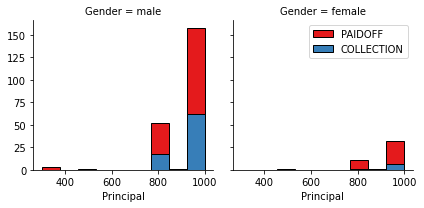

In [99]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

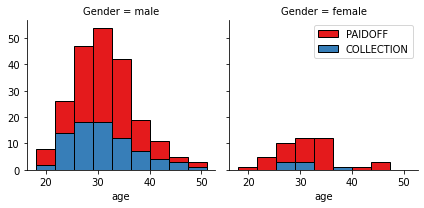

In [100]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


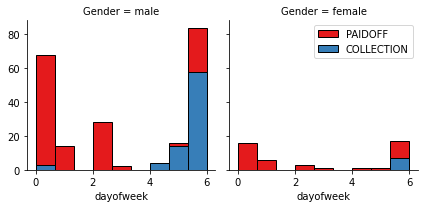

In [101]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()



We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [102]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values



Let's look at gender:


In [103]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay their loans while only 73 % of males pay their loan


Let's convert male to 0 and female to 1:


In [104]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [105]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [106]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [107]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection


Let's define feature sets, X:


In [108]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [109]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [110]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [111]:
# Split train and test data using train_loan.csv
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 10)

k_s = 15 # maximum k guess

# empty arrays to plot k values vs accuracy
mean_acc = np.zeros((k_s-1))
std_acc = np.zeros((k_s-1))

# Plot to see which k in the best
for k in range(1,k_s):
    neigh = KNN(n_neighbors = k).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[k-1] = metrics.accuracy_score(y_test, yhat) # accuracy array
    std_acc[k-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0]) # standard deviation

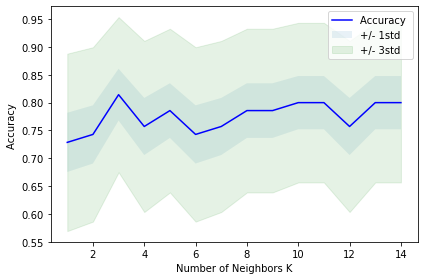

In [112]:
# Visualize k range
plt.plot(range(1,k_s),mean_acc,'b')
plt.fill_between(range(1,k_s),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,k_s),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1std','+/- 3std'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors K')
plt.tight_layout()
plt.show()


In [113]:
#Extract the best k
k_best = np.argmax(mean_acc) + 1
print('The k number with highest mean acc is k=', k_best)

# Use k best to output prediction
neigh = KNN(n_neighbors = k_best).fit(X_train,y_train)
yhat_KNN=neigh.predict(X_test)

print('First 5 predictions with k=3:', yhat[0:5])


The k number with highest mean acc is k= 3
First 5 predictions with k=3: ['COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION']


# Decision Tree


In [114]:
from sklearn.tree import DecisionTreeClassifier as DTC

In [115]:
# Call model
loantree = DTC(criterion = "entropy", max_depth = 4)

# Fit model
loantree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [116]:
# Test model
ytree = loantree.predict(X_test)
print(ytree[0:5], y_test[0:5])

['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'] ['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']


# Support Vector Machine


In [117]:
from sklearn import svm

# fit data
svm_linear = svm.SVC(kernel ='linear')
svm_linear.fit(X_train,y_train)

svm_poly = svm.SVC(kernel ='poly')
svm_poly.fit(X_train,y_train)

svm_sig = svm.SVC(kernel ='sigmoid')
svm_sig.fit(X_train,y_train)

svm_rbf = svm.SVC(kernel ='rbf')
svm_rbf.fit(X_train,y_train)


SVC()

In [118]:
# Predict using test data
yhat_linear = svm_linear.predict(X_test)
yhat_poly = svm_poly.predict(X_test)
yhat_sig = svm_sig.predict(X_test)
yhat_rbf = svm_rbf.predict(X_test)


In [119]:
# choose which one of these kernel is best using metrics accuracy score

from sklearn.metrics import accuracy_score
print("Linear accurary:", accuracy_score(y_test, yhat_linear))
print("Poly accurary:", accuracy_score(y_test, yhat_poly))
print("Sigmoid accurary:", accuracy_score(y_test, yhat_sig))
print("RBF accurary:", accuracy_score(y_test, yhat_rbf))

#comment
print("Based on these metrics, linear kernel has the best accuracy.")

Linear accurary: 0.8
Poly accurary: 0.7857142857142857
Sigmoid accurary: 0.7714285714285715
RBF accurary: 0.7857142857142857
Based on these metrics, linear kernel has the best accuracy.


# Logistic Regression


In [120]:
from sklearn.linear_model import LogisticRegression 

#convert y_train to numerics
# Convert y_test for log_score later
loan_to_binary = preprocessing.LabelEncoder()
loan_to_binary.fit(['PAIDOFF','COLLECTION'])
y_train_num = loan_to_binary.transform(y_train)
y_test_num = loan_to_binary.transform(y_test)
print(y_train_num[0:10])
print(y_test_num[0:10])

# make models
LR1 = LogisticRegression(C=0.01, solver ='liblinear').fit(X_train, y_train) 
LR2 = LogisticRegression(C=0.01, solver ='newton-cg').fit(X_train, y_train) 
LR3 = LogisticRegression(C=0.01, solver ='lbfgs').fit(X_train, y_train) 
LR4 = LogisticRegression(C=0.01, solver ='sag').fit(X_train, y_train) 
LR5 = LogisticRegression(C=0.01, solver ='saga').fit(X_train, y_train) 

[1 1 1 1 1 1 1 0 1 0]
[1 1 1 1 1 1 1 0 1 1]


In [121]:
# prediction
yhat_LR1 = LR1.predict(X_test)
yhat_LR2 = LR2.predict(X_test)
yhat_LR3 = LR3.predict(X_test)
yhat_LR4 = LR4.predict(X_test)
yhat_LR5 = LR5.predict(X_test)

print(yhat[0:5], yhat_LR1[0:5])

['COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION'] ['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']


In [122]:
# See accuarcy for the best Logistic Regression model

print("LR liblinear:", accuracy_score(y_test, yhat_LR1))
print("LR Newton-cg:", accuracy_score(y_test, yhat_LR2))
print("LR LBFGS:", accuracy_score(y_test, yhat_LR3))
print("LR Sag:", accuracy_score(y_test, yhat_LR4))
print("LR Saga:", accuracy_score(y_test, yhat_LR5))

print('In this case, i guess it does not matter which solver we choose.')

LR liblinear: 0.8
LR Newton-cg: 0.8
LR LBFGS: 0.8
LR Sag: 0.8
LR Saga: 0.8
In this case, i guess it does not matter which solver we choose.


# Model Evaluation using Test set


In [123]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss


First, download and load the test set:


In [124]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2022-02-02 23:00:48--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2022-02-02 23:00:48 (91.2 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation


In [125]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [126]:
# Convert date time
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])

test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df.head()

# Do the same processing as above
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df.head()

# One hot encoding, converting categoricals to numerics
Test_Feature = test_df[['Principal','terms','age','Gender','weekend']]
Test_Feature = pd.concat([Test_Feature,pd.get_dummies(test_df['education'])], axis=1)
Test_Feature.drop(['Master or Above'], axis = 1,inplace=True)
Test_Feature.head()
#Test_Feature.shape

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [127]:
# Define X_test
X_test2 = Test_Feature
# Normalize Data
X_test2= preprocessing.StandardScaler().fit(X_test2).transform(X_test2)
#X_test2

In [128]:
# Define y_test
y_test2 = test_df['loan_status'].values
print(y_test2[0:10])
# Convert y_test for log_score later
loan_to_binary = preprocessing.LabelEncoder()
loan_to_binary.fit(['PAIDOFF','COLLECTION'])
y_test2_num = loan_to_binary.transform(y_test2)
print(y_test2_num[0:10])

['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
[1 1 1 1 1 1 1 1 1 1]


In [129]:
# Use model to predict and evaluate

from sklearn.metrics import classification_report, confusion_matrix
import itertools


# KNN
yhat_KNN2 =neigh.predict(X_test2)
yhat_KNN2 = loan_to_binary.transform(yhat_KNN2)

# Decision Tree
yhat_DT2 = loantree.predict(X_test2)
yhat_DT2 = loan_to_binary.transform(yhat_DT2)

# SVM
yhat_SVM = svm_linear.predict(X_test2)
yhat_SVM = loan_to_binary.transform(yhat_SVM)

# Logistic Regression
yhat_LR_test2 = LR1.predict(X_test2)
yhat_LR_test2 = loan_to_binary.transform(yhat_LR_test2)


KKN Jaccard 0.6122448979591837
KKN Jaccard 0.7594936708860761


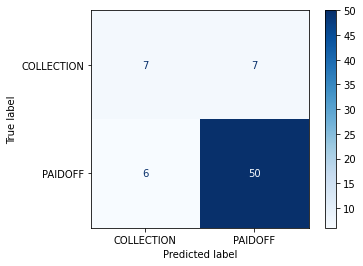

In [130]:
# Visualization KNN

from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(neigh, X_test, y_test, cmap='Blues')

# Evaluation KNN
print('KKN Jaccard', jaccard_score(y_test2_num, yhat_KNN2))
print('KKN Jaccard', f1_score(y_test2_num, yhat_KNN2))


Decision Tree Jaccard 0.7547169811320755
Decision Tree Jaccard 0.8602150537634409


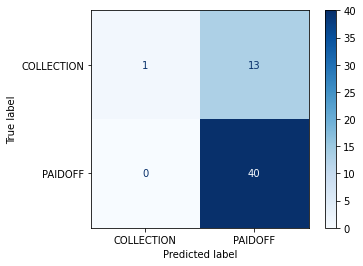

In [131]:
# Visualization Decision Tree

plot_confusion_matrix(loantree, X_test2, y_test2, cmap='Blues')

# Evaluation Decision Tree
print('Decision Tree Jaccard', jaccard_score(y_test2_num, yhat_DT2))
print('Decision Tree Jaccard', f1_score(y_test2_num, yhat_DT2))

SVM Jaccard 0.7407407407407407
SVM F1 0.851063829787234


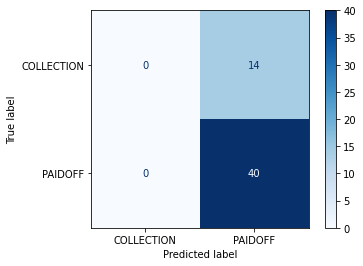

In [132]:
# Visualization SVM

plot_confusion_matrix(svm_linear, X_test2, y_test2, cmap='Blues')

# Evaluation SVM
print('SVM Jaccard', jaccard_score(y_test2_num, yhat_SVM))
print('SVM F1', f1_score(y_test2_num, yhat_SVM))

Logistic Regression Jaccard 0.7407407407407407
Logistic Regression F1 0.851063829787234
Logistic Regression log-loss 8.95470488690319


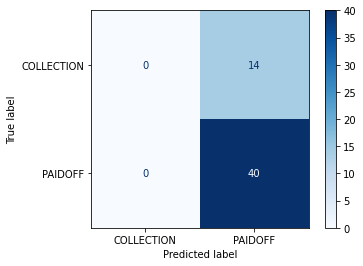

In [133]:
# Visualization Logistic Regression

plot_confusion_matrix(svm_linear, X_test2, y_test2, cmap='Blues')

# Evaluation Logistic Regression
print('Logistic Regression Jaccard', jaccard_score(y_test2_num, yhat_LR_test2))
print('Logistic Regression F1', f1_score(y_test2_num, yhat_LR_test2))
print('Logistic Regression log-loss', log_loss(y_test2_num, yhat_LR_test2))

# Comments and Evaluation

Out of the 4 classification methods, Logistic Regression has the best performance while KNN has the worst performance, using the F1 and Jaccard score as metrics.
KNN is expected to underperformed due to its simplistic structure. Decision Tree, SVM, and Logistic Regression all have very similar F1 and Jaccard score, however, Logistic Regression also gives the probability/certainty of the predicted score. Decision Tree and SVM are also proned to overfitting, and SVM could be computationally expensive given large data. 

Therefore, Logistic Regression is the best model out of all these 4 methods in predicting loans.

# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | 0.6122       | 0.7595        | NA      |
| Decision Tree      | 0.7547       | 0.8602        | NA      |
| SVM                | 0.7407       | 0.8511        | NA      |
| LogisticRegression | 0.7407       | 0.8511        | 8.9547       |


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
